In [1]:
%load_ext autoreload
%autoreload 2
import os
import motti
motti.append_current_dir(os.path.abspath(''))

'/home/lupin/Documents/github/prim_diffusion/src'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from model.pipeline_ddpm import DDPMPipelineV2
from model.pipeline_ddim import DDIMPipelineV2
from model.DDPM import DiffusionModel
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler, DDIMPipeline, DDPMPipeline
from PIL import Image

In [15]:
ckpt_path = "../../ckpt/20241113-145017/epoch=80-step=1215.ckpt"
ckpt = torch.load(ckpt_path, map_location="cpu")

In [16]:
unet_config = UNet2DModel.load_config("../../config/unet.json")
scheduler_config = DDPMScheduler.load_config("../../config/scheduler.json")
unet = UNet2DModel.from_config(unet_config)
scheduler = DDPMScheduler.from_config(scheduler_config)
ddim_scheduler = DDIMScheduler.from_config(scheduler_config)

In [17]:
d = {}
for k, v in ckpt["state_dict"].items():
    if k.startswith("model."):
        d[k[6:]] = v
unet.load_state_dict(d)

<All keys matched successfully>

In [18]:
ddpm_pipe = DDPMPipelineV2(
    unet=unet,
    scheduler=scheduler,
)

ddim_pipe = DDIMPipelineV2(
    unet=unet,
    scheduler=ddim_scheduler,
)

In [ ]:
images_per_step = []

In [22]:
import numpy as np

def NMS(img):
    # 在第三个维度上找到每个位置的最大值
    max_values = np.max(img, axis=2, keepdims=True)
    
    # 创建布尔掩码，将不等于最大值的元素置零
    img[img != max_values] = 0
    img[img == max_values] = 1
    return img

def capture_image(image, t):
    global images_per_step
    images_per_step.append(image.cpu().clone())

In [46]:
images_per_step = []
y = ddpm_pipe(output_type="numpy", callback=capture_image)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:24<00:00,  6.92it/s]


In [21]:
images_per_step = []
y = ddim_pipe(output_type="numpy", num_inference_steps=50, callback=capture_image)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:07<00:00,  7.03it/s]


In [23]:
images_per_step[0].shape

torch.Size([1, 4, 64, 64])

In [47]:
images = []
for x in images_per_step:
    x = (x / 2 + 0.5).clamp(0, 1)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    x = x[0, ...]# x = x.squeeze()
    img = ddpm_pipe.numpy_to_pil(x[..., 1:])[0]
    images.append(img)

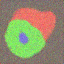

In [48]:
x
images[0].save("ddpm.gif", save_all=True, append_images=images[1:], duration=0.2, loop=0)

In [50]:
images[0].save("ddpm.gif", save_all=True, append_images=images[1:], duration=0.2, loop=0)

In [47]:
pipe = ddpm_pipe

n = 0
for i in range(25):
    y = pipe(
        batch_size=8, 
        num_inference_steps=1000, 
        output_type="numpy",
        mean=0.5,
        std=0.5)
    break

  3%|▎         | 32/1000 [00:21<10:57,  1.47it/s]


KeyboardInterrupt: 

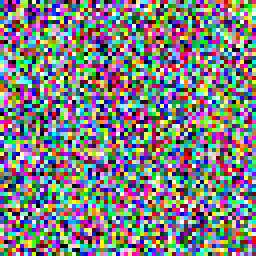

In [61]:
images[0].

In [88]:
from PIL import Image, ImageDraw, ImageFont

# 假设 images 是包含 1000 张 PIL 图片的列表
output_images = []

# 使用默认字体（可选），但确保系统上有合适的字体文件
try:
    font = ImageFont.truetype("arial.ttf", 50)  # 字体文件路径可能需要调整
except IOError:
    font = ImageFont.load_default(30)

In [89]:
font.size

30

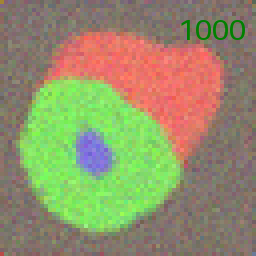

In [105]:
# 遍历每张图片，并对其进行处理
for idx, img in enumerate(N):
    idx = 50 * idx
    # 创建一个新的 256x256 白色背景图像
    new_img = Image.new("RGB", (256, 256), color="white")
    
    # 将原图粘贴到新图的左上角，不用插值
    new_img.paste(img, (0, 0))
    
    # 在右上角绘制序号
    draw = ImageDraw.Draw(new_img)
    text = str(idx)
    bbox = draw.textbbox((0, 0), text, font=font)  # 获取文本边界框
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    x = 256 - text_width - 10  # 右上角留 10 像素的间距
    y = 10  # 顶部 10 像素的间距
    draw.text((x, y), text, fill="green", font=font)
    
    # 将处理好的图片添加到输出列表
    output_images.append(new_img)

# 此时，output_images 列表中保存了所有处理好的图片
# 你可以选择显示或保存其中的一部分
output_images[-1]  # 显示第一张处理好的图片


In [106]:
output_images[0].save("ddpm_fast.gif", save_all=True, append_images=output_images[1:], duration=0.001, loop=0)

In [ ]:
len(images)

1000

In [62]:
L = [x.resize((256, 256), 0) for x in images]

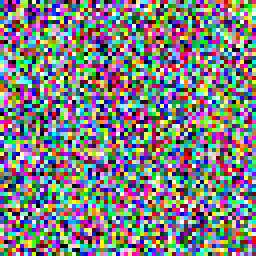

In [63]:
L[0]

In [93]:
pipe = ddim_pipe

n = 0
for i in range(1):
    y = pipe(
        batch_size=2, 
        num_inference_steps=100, 
        output_type="numpy",
        mean=0.5,
        std=0.5)

100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


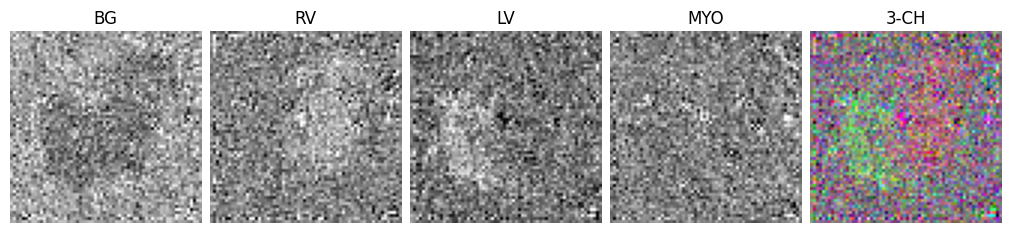

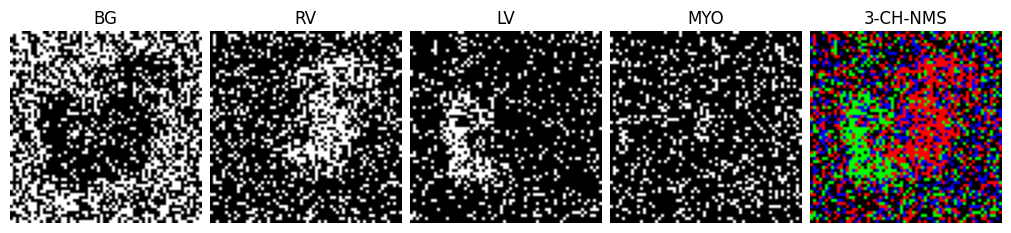

In [95]:
for img in y.images:
    fig, axs = plt.subplots(1, 5, figsize=(10, 3), constraL
        axs[j].imshow(img[..., j], cmap="gray", vmin=0, vmax=1)
    axs[-1].imshow(img[..., 1:])
    
    for j in range(5):
        axs[j].axis("off")
        axs[j].set_title(labels[j])

    fig.savefig(f"../../tmp/{n:03d}.png")
    
    img = NMS(img)
    fig, axs = plt.subplots(1, 5, figsize=(10, 3), constrained_layout=True)
    labels = ["BG", "RV", "LV", "MYO", "3-CH-NMS"]
    for j in range(4):
        axs[j].imshow(img[..., j], cmap="gray", vmin=0, vmax=1)
    axs[-1].imshow(img[..., 1:])
    
    for j in range(5):
        axs[j].axis("off")
        axs[j].set_title(labels[j])

    fig.savefig(f"../../tmp/{n:03d}_nms.png")

    n += 1

In [96]:
import imageio

In [97]:
imageio.mimsave('output.gif', L, duration=0.01)

In [102]:
N = []
for i in range(0, 1000, 50):
    N.append(L[i])
N.append(L[-1])

In [107]:
imageio.mimsave('output.gif', N, duration=0.1)